<a href="https://colab.research.google.com/github/JulioCezar1111/Projeto27/blob/main/petrobas_lstm_pandemia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Instalando data set**

In [ ]:
!wget https://raw.githubusercontent.com/lucaslattari/neural-network-series/main/11/PETR4.SA2.csv

--2022-06-17 18:37:39--  https://raw.githubusercontent.com/lucaslattari/neural-network-series/main/11/PETR4.SA2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154828 (151K) [text/plain]
Saving to: ‘PETR4.SA2.csv’

PETR4.SA2.csv       100%[===================>] 151.20K  --.-KB/s    in 0.02s   

2022-06-17 18:37:39 (6.48 MB/s) - ‘PETR4.SA2.csv’ saved [154828/154828]



# **Importando DataFrame**

In [ ]:
import pandas as pd

df = pd.read_csv('/content/PETR4.SA2.csv')
display(df.head())
print('\n')
df.describe()
print('\n')
df.info()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,13.660646,30182600
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,14.153233,30552600
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,14.174045,36141000
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,13.931217,28069600
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,13.528824,29091300






<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2234 entries, 0 to 2233
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2234 non-null   object 
 1   Open       2234 non-null   float64
 2   High       2234 non-null   float64
 3   Low        2234 non-null   float64
 4   Close      2234 non-null   float64
 5   Adj Close  2234 non-null   float64
 6   Volume     2234 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 122.3+ KB


# **E se removéssemos o período da pandemia?**

In [ ]:
df["Date"]

0       2013-01-02
1       2013-01-03
2       2013-01-04
3       2013-01-07
4       2013-01-08
           ...    
2229    2021-12-23
2230    2021-12-27
2231    2021-12-28
2232    2021-12-29
2233    2021-12-30
Name: Date, Length: 2234, dtype: object

In [ ]:
from datetime import datetime as dt

df["Date"] = pd.to_datetime(df["Date"]) #converte para tipo datetime

df["Date"]

0      2013-01-02
1      2013-01-03
2      2013-01-04
3      2013-01-07
4      2013-01-08
          ...    
2229   2021-12-23
2230   2021-12-27
2231   2021-12-28
2232   2021-12-29
2233   2021-12-30
Name: Date, Length: 2234, dtype: datetime64[ns]

In [ ]:
df = df[(df["Date"] < '2020-08-01')] #só vou trabalhar com o período de 2013 até junho de 2020

# **Tratar DataFrame**

In [ ]:
df.dropna()

len(df)

1885

# **Visualizar os dados**

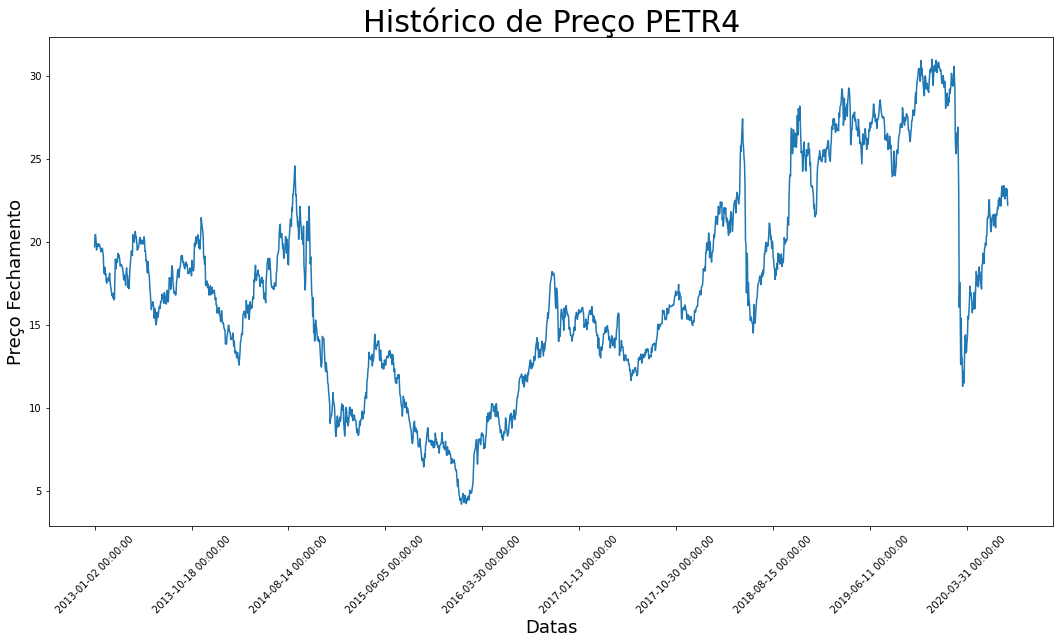

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (18,9))
plt.plot(df['Close'])
plt.xticks(range(0,df.shape[0],200), df['Date'].loc[::200], rotation=45)
plt.xlabel('Datas', fontsize=18)
plt.ylabel('Preço Fechamento', fontsize=18)
plt.title("Histórico de Preço PETR4", fontsize=30)
plt.show()

In [ ]:
days_time_step = 15

# **Separação Teste e Treino**

In [ ]:
prices = df['Close']

In [ ]:
import numpy as np
training_size = int(len(prices) * 0.95)
test_size = len(prices) - training_size
train_data, input_data = np.array(prices[0:training_size]), np.array(prices[training_size - days_time_step:])
test_data = np.array(prices[training_size:])

train_data.shape, test_data.shape

((1790,), (95,))

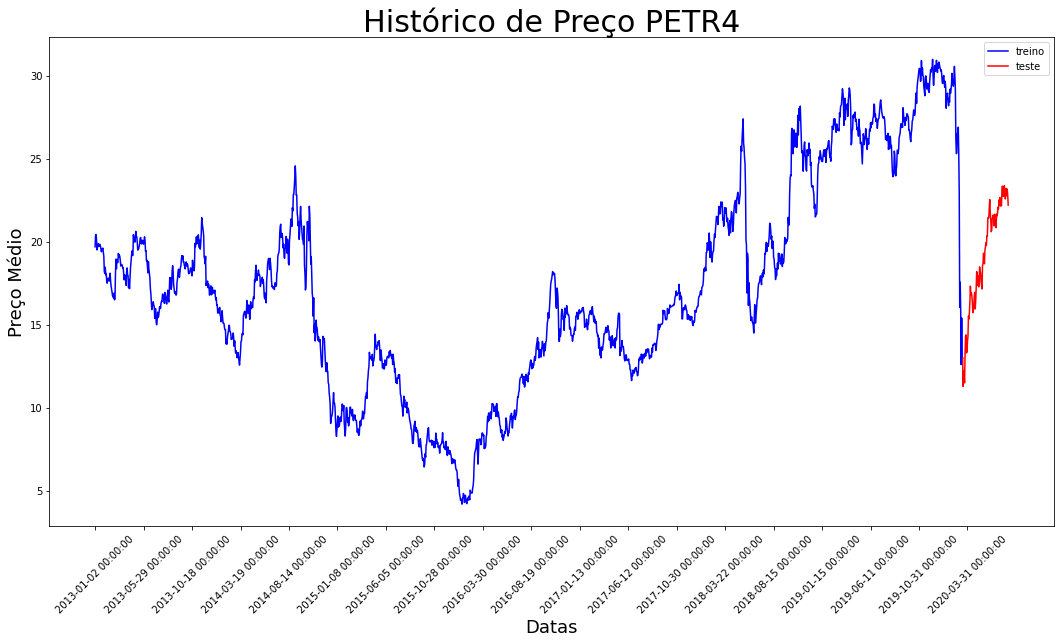

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (18,9))
plt.plot(df['Close'].loc[0:train_data.shape[0]], color = 'blue', label = 'treino')
plt.plot(df['Close'].loc[train_data.shape[0]:], color = 'red', label = 'teste')
plt.xticks(range(0,df.shape[0],100), df['Date'].loc[::100], rotation=45)
plt.xlabel('Datas', fontsize=18)
plt.ylabel('Preço Médio', fontsize=18)
plt.title("Histórico de Preço PETR4", fontsize=30)
plt.legend()
plt.show()

# **Normalização dos Dados**

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
train_data_norm = scaler.fit_transform(np.array(train_data).reshape(-1,1))
test_data_norm = scaler.transform(np.array(input_data).reshape(-1,1))
val_data_norm = scaler.transform(np.array(test_data).reshape(-1,1))

train_data_norm

array([[0.57863286],
       [0.60515505],
       [0.6062757 ],
       ...,
       [0.3137841 ],
       [0.4183788 ],
       [0.33208817]])

# **Pré-processamento (Gerando X e y)**

In [ ]:
#treino
X_train, y_train = [], []
for i in range(days_time_step, len(train_data)):
    X_train.append(train_data_norm[i-days_time_step:i])
    y_train.append(train_data_norm[i])
    
#teste
X_test = []
for i in range(days_time_step, days_time_step + len(test_data)):
    X_test.append(test_data_norm[i-days_time_step:i])
    
#val
X_val, y_val = [], []
for i in range(days_time_step, len(test_data)):
    X_val.append(val_data_norm[i-days_time_step:i])
    y_val.append(val_data_norm[i])

#converter tudo pra matriz numpy
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
X_val = np.array(X_val)
y_val = np.array(y_val)

X_test.shape

(95, 15, 1)

# **Treinamento de Rede Neural**

In [ ]:
import tensorflow as tf

tf.__version__

'2.8.2'

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import SGD

model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(days_time_step, 1)))
#model.add(Dropout(0.3))
model.add(LSTM(100, return_sequences=False, input_shape=(days_time_step, 1)))
#model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
h = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=30, batch_size=32)

Epoch 1/30
56/56 [==============================] - 6s 44ms/step - loss: 0.0184 - val_loss: 0.0020
Epoch 2/30
56/56 [==============================] - 2s 29ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 3/30
56/56 [==============================] - 2s 28ms/step - loss: 0.0019 - val_loss: 9.9826e-04
Epoch 4/30
56/56 [==============================] - 2s 28ms/step - loss: 0.0017 - val_loss: 9.6542e-04
Epoch 5/30
56/56 [==============================] - 2s 28ms/step - loss: 0.0017 - val_loss: 7.6392e-04
Epoch 6/30
56/56 [==============================] - 2s 28ms/step - loss: 0.0015 - val_loss: 8.4477e-04
Epoch 7/30
56/56 [==============================] - 2s 28ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 8/30
56/56 [==============================] - 2s 28ms/step - loss: 0.0013 - val_loss: 7.2374e-04
Epoch 9/30
56/56 [==============================] - 2s 31ms/step - loss: 0.0011 - val_loss: 9.3251e-04
Epoch 10/30
56/56 [==============================] - 3s 50ms/step - loss: 0.0011 - va

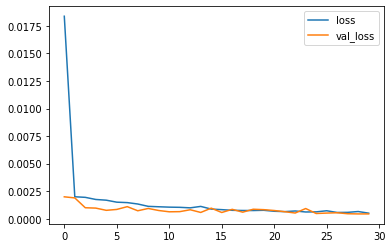

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h.history["loss"], label='loss')
plt.plot(h.history["val_loss"], label='val_loss')
plt.legend()

# **Avaliação de Resultados**

In [ ]:
#predição de valores pela rede
predict = model.predict(X_test)

#transformação inversa do normalizador, pra que possamos plotar no gráfico os resultados
predict = scaler.inverse_transform(predict)
real = test_data

predict.shape

(95, 1)

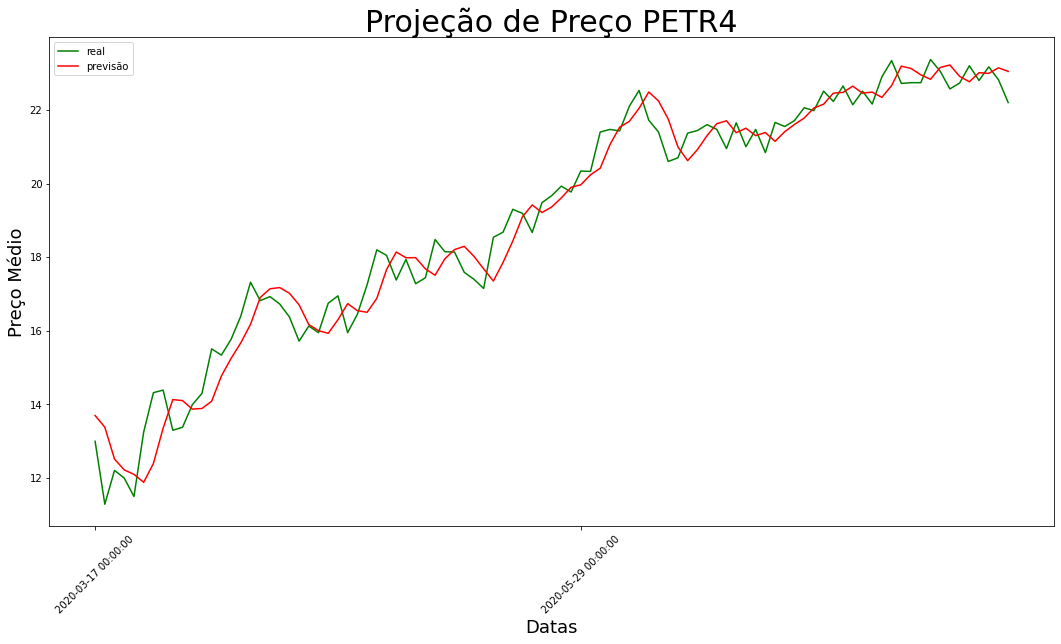

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (18,9))
plt.plot(real, color = 'green', label = 'real')
plt.plot(predict, color = 'red', label = 'previsão')
plt.xticks(range(0, len(real), 50), df['Date'].iloc[- len(real)::50], rotation=45)
plt.xlabel('Datas', fontsize=18)
plt.ylabel('Preço Médio', fontsize=18)
plt.title("Projeção de Preço PETR4", fontsize=30)
plt.legend()
plt.show()

In [ ]:
import math
from sklearn.metrics import mean_squared_error
mean_squared_error(real, predict)

0.43361479777105744